In [28]:
import os
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

from skimage import data, util
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split

from gmm_seg_classifier import GaussianModel, GaussianMixtureModel
from roipoly import RoiPoly

# suppress depreciation warning from numpy 1.25.0
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# make some utils
def read_img_to_array(fp):
    # read image file into 8-bit encoded image
    img = cv2.imread(fp)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = util.img_as_ubyte(img)
    return img

def read_mask_to_array(fp):
    # read image file into binary mask
    img = cv2.imread(fp)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = util.img_as_ubyte(img)
    _, binary_mask = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)
    return binary_mask > 0

In [19]:
train_path = 'data/img/train'
mask_path = 'data/mask/train'

# import image
filenames = os.listdir(train_path)

for f in filenames:
    assert f.endswith(('.png', '.jpg'))

train_files, test_files = train_test_split(filenames, test_size=0.2)
print(len(train_files), len(test_files))

20 5


In [4]:
# train
X_cone = []
X_bg = []
for filename in train_files:
    # assemble into set of pixels X
    img = read_img_to_array(os.path.join(train_path,filename))
    mask = read_mask_to_array(os.path.join(mask_path, filename))
    cone = img[mask]
    background = img[np.invert(mask)]

    X_cone.append(cone)
    X_bg.append(background)
    
X_cone = np.concatenate(X_cone)
X_bg = np.concatenate(X_bg)

n_cone_pixel = X_cone.shape[0]
n_bg_pixel = X_bg.shape[0]
p_cone = n_cone_pixel / (n_cone_pixel + n_bg_pixel)

cone_gaussian_model = GaussianModel()
bg_gaussian_model = GaussianModel()

cone_gaussian_model.fit(X_cone)
bg_gaussian_model.fit(X_bg)

In [23]:
# image processing
def classify_image_pixels(image):
    W, H, _ = image.shape
    mask = np.zeros((W,H))
    for x in range(W):
        for y in range(H):
            pixel = image[x,y,:]
            p_x_cone = cone_gaussian_model.predict(pixel)
            p_x_bg = bg_gaussian_model.predict(pixel)
            p_x = ((p_x_cone * p_cone) + p_x_bg * (1 - p_cone))
            p_cone_x = (p_x_cone * p_cone) / p_x
            mask[x,y] = p_cone_x[0]

    return mask 


def draw_triangle_around_positive_pixels(image, thresh):
    mask = classify_image_pixels(image)

    #dilation and erosion to clean up
    kernel = np.ones((3, 3), np.uint8)
    mask_cleaned = mask
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel, iterations=2)
    binary_mask = mask_cleaned > thresh

    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    triangles = []
    for cnt in contours:
        # approximate the contour to reduce the number of points
        epsilon = 0.01 * cv2.arcLength(cnt, True)
        cnt = cv2.approxPolyDP(cnt, epsilon, True)

        x, y, w, h = cv2.boundingRect(cnt)
        t = np.array([
            [x + w // 2, y], # top
            [x, y + h], # right
            [x + w, y + h] # left
        ])

        # geometry constraint
        w_h_ratio = 7.5 / 17
        if math.isclose((w / h), w_h_ratio, rel_tol=0.4):
            triangles.append(t)
            cv2.drawContours(image, [t], 0, (0, 255, 0), 2)  # Green, tickness 2

    return image, triangles


In [34]:
# geometry processing
def triangle_geometry(triangle):
    centroid = np.mean(triangle, axis=0).squeeze().astype(int)
    x = centroid[0]
    y = centroid[1]

    f = 50 # hand-calculated focal length
    h = np.abs(triangle[0][1] - triangle[1][1])
    w = np.abs(triangle[1][0] - triangle[2][0])
    # average of distance estimates from height and width
    d_1 = f * 17 / h
    d_2 = f * 7.5 / w
    d = (d_1 + d_2) / 2

    return x, y, d

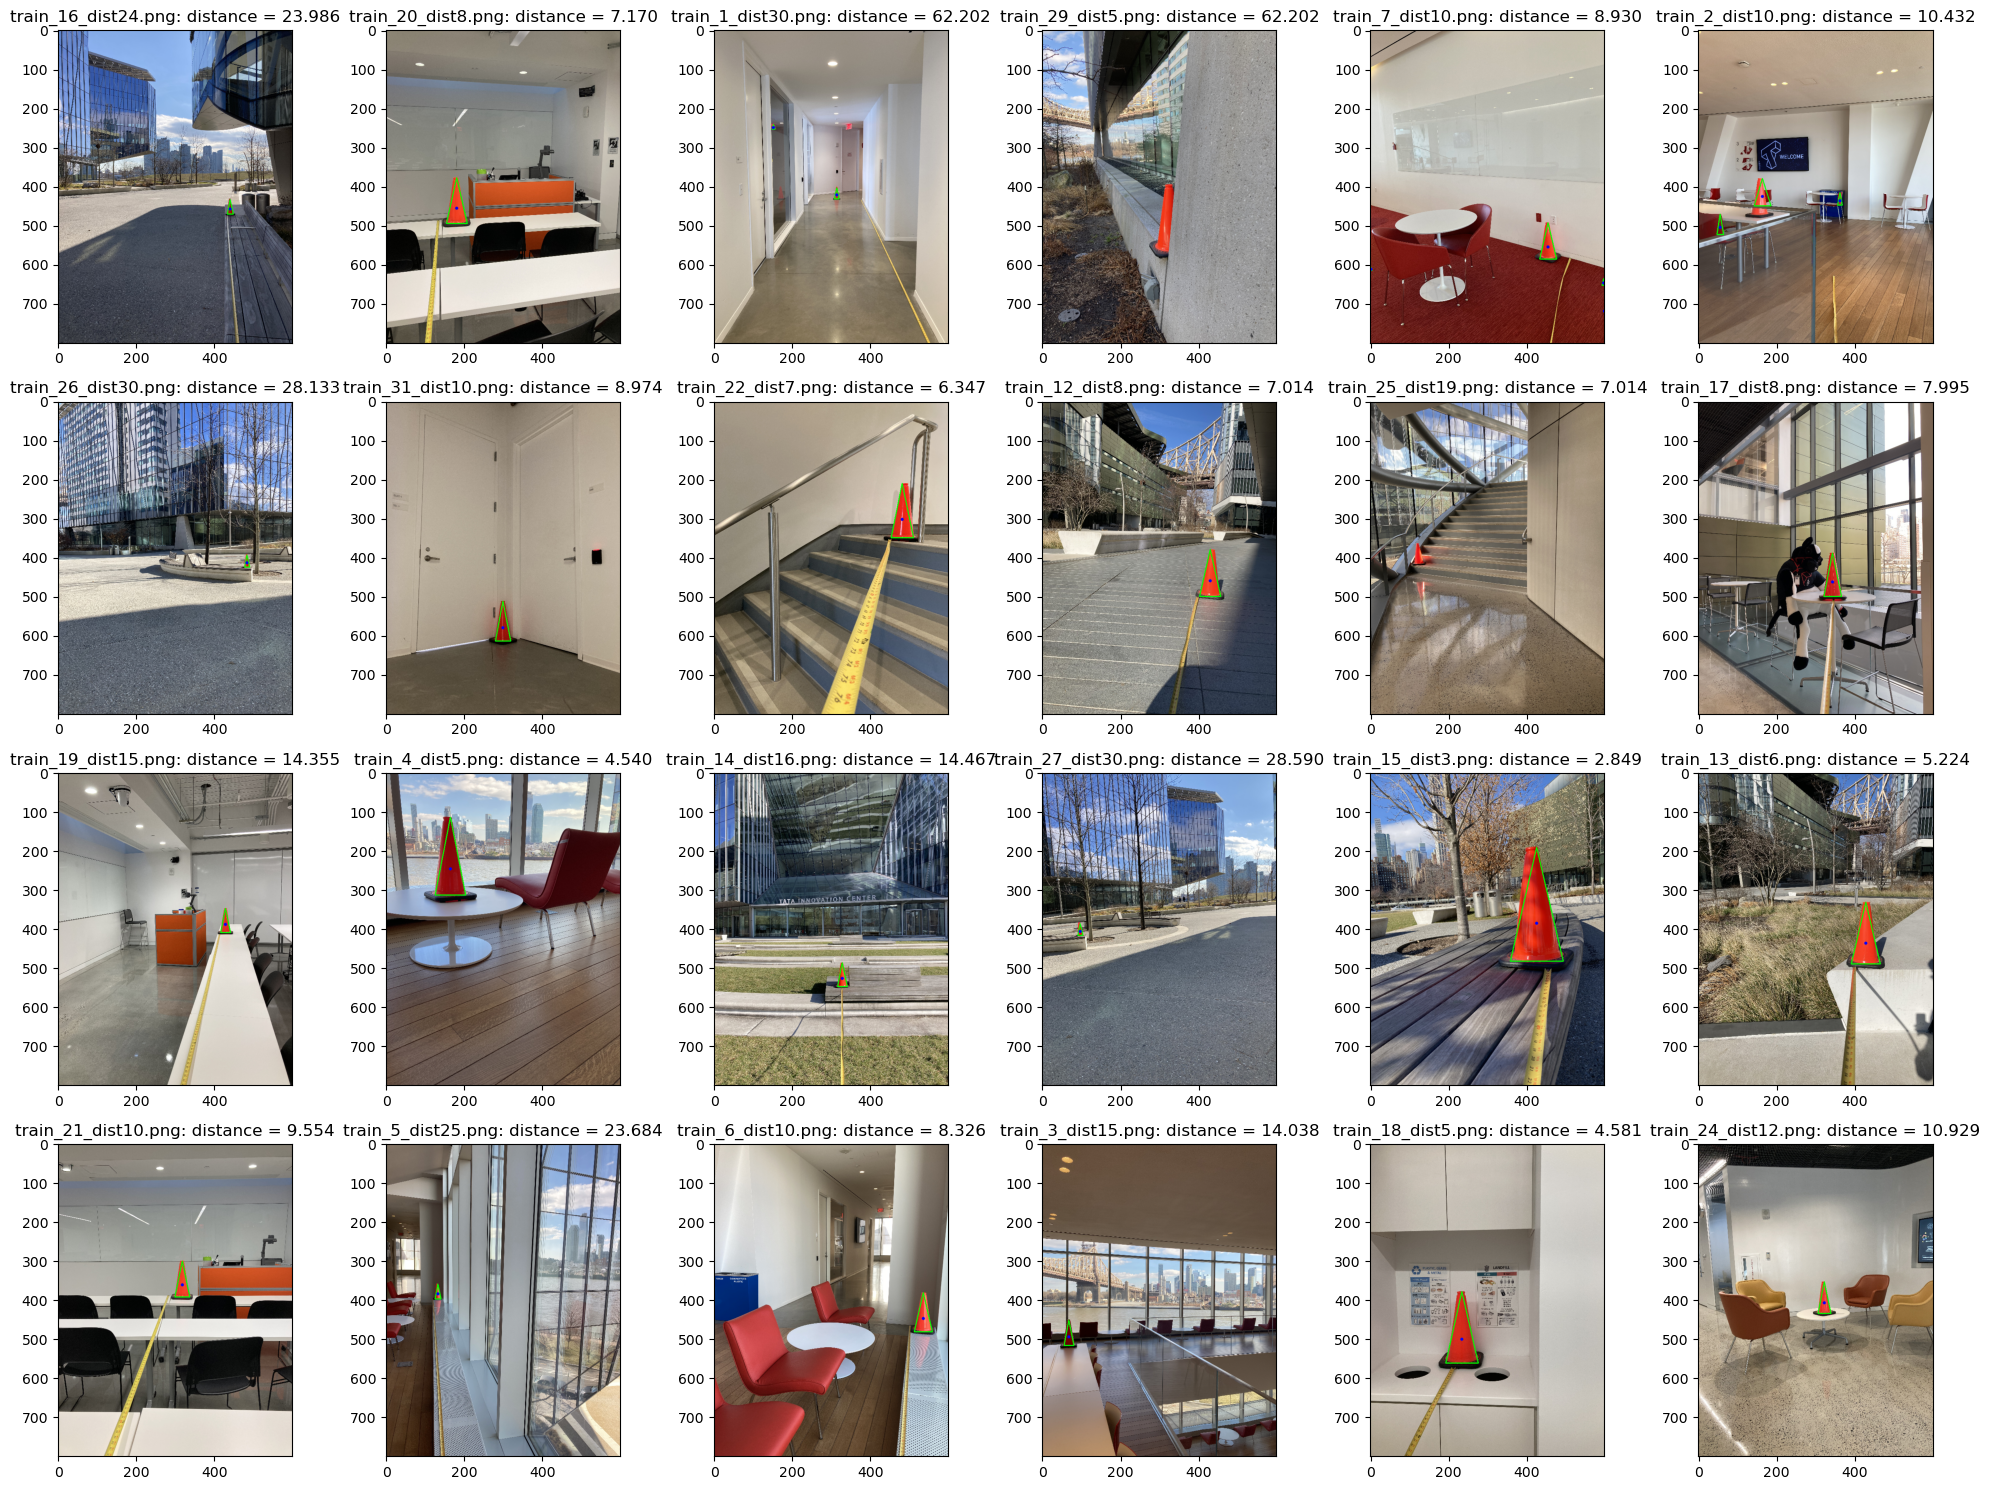

In [35]:
# test
######################################
# params
target_files = filenames
thresh = 0.99
######################################

shapes = []
# set up nice plots
n_subplots = len(target_files)
rows = math.ceil(len(filenames) / 8)
fig, axs = plt.subplots(rows, 6, figsize=(20, 15))

for ax, filename in zip(axs.flat, target_files):
    # assemble into set of pixels X
    img = read_img_to_array(os.path.join(train_path,filename))
    img_overlay, triangles = draw_triangle_around_positive_pixels(img, thresh)
    
    for t in triangles:
        shapes.append(t)
        x, y, d = triangle_geometry(t)
        # draw blue dot at centroid
        cv2.circle(img_overlay, (x,y), radius=4, color=(0, 0, 255), thickness=-1)

        # reset 
        x, y, d = None

    ax.imshow(img_overlay)
    ax.set_title(f'{filename}: distance = {d:.3f}')

plt.tight_layout()
plt.show()

TODO
- [x] Fix plotting: images with no triangles should still plot
- [ ] Format array of returns
- [ ] Set up test notebook
- [ ] Verify on a clean install
- [ ] Can we get quantization to work and produce speedup?